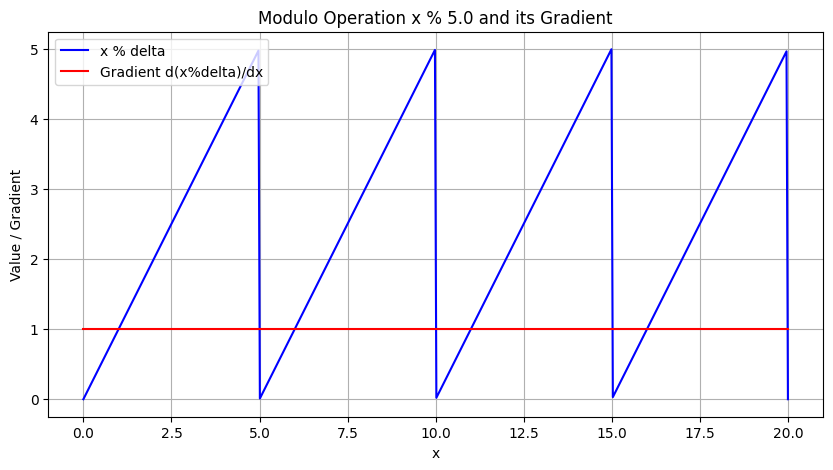

In [7]:
import torch
import matplotlib.pyplot as plt

# Values
delta = 5.0
x = torch.linspace(0, 20, 500, requires_grad=True)
y = x % delta

# Backprop to get gradients
y.sum().backward()
grad = x.grad

# Plot
plt.figure(figsize=(10,5))
plt.plot(x.detach(), y.detach(), label="x % delta", color="blue")
plt.plot(x.detach(), grad, label="Gradient d(x%delta)/dx", color="red")
plt.xlabel("x")
plt.ylabel("Value / Gradient")
plt.title(f"Modulo Operation x % {delta} and its Gradient")
plt.grid(True)
plt.legend()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
grid = pd.read_pickle("outputs_in_instab_strip.pkl")
print(grid.columns)

Index(['F_l_0', 'F_l_1', 'F_l_2', 'O1_l_0', 'O1_l_1', 'O1_l_2', 'O2_l_0',
       'O2_l_1', 'O2_l_2', 'O3_l_0', 'O3_l_1', 'O3_l_2', 'O4_l_0', 'O4_l_1',
       'O4_l_2', 'O5_l_0', 'O5_l_1', 'O5_l_2', 'O6_l_0', 'O6_l_1', 'O6_l_2',
       'O7_l_0', 'O7_l_1', 'O7_l_2', 'O8_l_0', 'O8_l_1', 'O8_l_2', 'O9_l_0',
       'O9_l_1', 'O9_l_2', 'delta_nu'],
      dtype='object')


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

# l values and columns
l_values = [0, 1, 2]
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

# Stack frequencies per l
X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  # shape (n_stars, n_modes_total)
delta_nu_values = grid["delta_nu"].values[:, np.newaxis]                   # shape (n_stars, 1)
mod_frequencies = X_frequencies % delta_nu_values

# Stack raw freq and mod freq
X = np.stack((X_frequencies, mod_frequencies), axis=-1)  # shape: (n_stars, n_modes, 2)

# Stack labels
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  # shape: (n_stars, n_modes_total)

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}")

# --- build tensors ---
X_tensor = torch.tensor(X, dtype=torch.float32)           # (N, P, 2)  with X[:,:,0]=freq, X[:,:,1]=mod (unused now)
y_tensor = torch.tensor(y, dtype=torch.long)              # (N, P)
dn_tensor = torch.tensor(grid["delta_nu"].values, dtype=torch.float32).unsqueeze(1)  # (N,1)

X_train, X_temp, y_train, y_temp, dn_train, dn_temp = train_test_split(
    X_tensor, y_tensor, dn_tensor, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test, dn_val, dn_test = train_test_split(
    X_temp, y_temp, dn_temp, test_size=0.5, random_state=42
)


# Print shapes
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)
Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])


In [3]:
size = 10000 # or for all models it would be: X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

torch.Size([10000, 30, 2])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

FAKE_CLASS = 3
DROPPED_CLASS = -1


class DeltaNuCorrection(nn.Module):
    def __init__(self, n_stars, delta_nu_hard):
        """
        n_stars: number of stars in the training set
        delta_nu_hard: (n_stars,) baseline Δν values for each star
        """
        super().__init__()
        self.register_buffer("delta_nu_hard", delta_nu_hard.clone())
        self.delta_nu_corr = nn.Parameter(torch.zeros_like(delta_nu_hard))
        self.eps = 1e-3

    def forward(self, frequencies, star_indices):
        """
        frequencies: (B,N) per-star frequencies
        star_indices: (B,) integer IDs of stars in batch
        returns: ν mod Δν for each star → (B,N)
        """
        delta = (self.delta_nu_hard[star_indices] +
                 self.delta_nu_corr[star_indices]).clamp_min(self.eps)  # (B,)
        delta = delta.unsqueeze(1)  # (B,1)
        mod_freq = frequencies % delta  # broadcasted (B,N)
        return mod_freq, delta.squeeze(1)


class PointNet(nn.Module):
    def __init__(self, num_classes=4, point_dim=2, aggregator="mean"):
        super().__init__()
        nfeat = 64
        a = 3
        self.conv_1_a = nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_1_b = nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_2 = nn.Conv1d(nfeat, nfeat, kernel_size=a, padding=1)
        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)
        self.aggregator = aggregator

    def forward(self, x, mask=None):
        """
        x: (B,N,2) with freq and mod-freq
        """
        B, N, _ = x.shape
        x_freq = x[:, :, 0].unsqueeze(1)  # (B,1,N)
        x_mod = x[:, :, 1].unsqueeze(1)   # (B,1,N)

        x = self.conv_1_a(x_freq) + self.conv_1_b(x_mod)
        x = F.relu(self.bn_1(x))
        x = F.relu(self.bn_2(self.conv_2(x)))

        if self.aggregator == "max":
            if mask is not None:
                m = (mask.unsqueeze(1) > 0).float()
                x = x.masked_fill(m == 0, -1e9)
            x = x.amax(dim=-1, keepdim=True)
        elif self.aggregator == "mean":
            if mask is None:
                x = x.mean(dim=-1, keepdim=True)
            else:
                m = (mask.unsqueeze(1) > 0).float()
                x = (x * m).sum(dim=-1, keepdim=True) / m.sum(dim=-1, keepdim=True).clamp_min(1.0)
        else:
            raise ValueError(f"Unknown aggregator type: {self.aggregator}")

        return x.view(B, -1)  # (B,64)


class SegmentationPointNet(nn.Module):
    def __init__(self, num_stars, delta_nu_hard, num_classes=4, aggregator="mean"):
        super().__init__()
        self.num_classes = num_classes
        self.delta_module = DeltaNuCorrection(num_stars, delta_nu_hard)
        self.base_pointnet = PointNet(num_classes=num_classes, point_dim=2, aggregator=aggregator)

        nhidden = 64
        nfeat = 64
        self.fc_1 = nn.Linear(nfeat + 2, nhidden)
        self.fc_2 = nn.Linear(nhidden, num_classes)

    def forward(self, x, star_indices, mask=None):
        """
        x: (B,N,2) but only x[:,:,0]=freq is used
        star_indices: (B,) mapping each star to its Δν
        """
        freq = x[:, :, 0]  # (B,N)
        modf, delta_used = self.delta_module(freq, star_indices)  # (B,N), (B,)

        # rebuild input with corrected mod-freq
        x2 = torch.stack([freq, modf], dim=2)  # (B,N,2)

        g = self.base_pointnet(x2, mask=mask)  # (B,64)
        g = g.unsqueeze(1).expand(-1, x2.shape[1], -1)  # (B,N,64)

        z = torch.cat([x2, g], dim=2)  # (B,N,66)
        z = F.relu(self.fc_1(z))
        out = F.log_softmax(self.fc_2(z), dim=2)  # (B,N,num_classes)

        return out, delta_used  # return logits and Δν values actually used


In [13]:
# Suppose grid has shape (122651, ...) and has a "delta_nu" column
delta_nu_hard = torch.tensor(grid["delta_nu"].values, dtype=torch.float32)

n_stars = len(delta_nu_hard)

model = SegmentationPointNet(
    num_stars=n_stars,
    delta_nu_hard=delta_nu_hard,
    num_classes=4,
    aggregator="mean"
)

## Training - only dropper

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time

class StarDataset(Dataset):
    def __init__(self, X, y, star_indices):
        self.X = X
        self.y = y
        self.star_indices = star_indices

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.star_indices[idx]

def apply_data_dropper(x, y, dropout_prob=0.3):
    """
    Randomly drop points by setting features to 0.0 and label to class 3.
    """
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()  # (B, N)
    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0
    y_dropped = y.clone()
    y_dropped[mask == 0] = 3  # mark dropped points
    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats

Nepoch = 150
nbatches = 100
batch_size = inpt.size(0) // nbatches

n_stars_total = X_train.shape[0] + X_val.shape[0]
initial_delta_nu_all = torch.tensor(grid["delta_nu"].values, dtype=torch.float32)  # (Ntotal,)

# model gets all stars (train+val), so validation indices are valid
model = SegmentationPointNet(
    n_stars=n_stars_total,
    delta_nu_hard=initial_delta_nu_all[:, None],
    num_classes=4,
    point_dimension=2,
    aggregator="mean",
)

# datasets
train_indices = torch.arange(X_train.shape[0])
val_indices   = torch.arange(X_train.shape[0], n_stars_total)

train_dataset = StarDataset(X_train, y_train, train_indices)
val_dataset   = StarDataset(X_val, y_val, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# optimizer with different lrs
optimizer = torch.optim.Adam([
    {'params': model.base_pointnet.parameters(), 'lr': 1e-3},
    {'params': model.fc_1.parameters(), 'lr': 1e-3},
    {'params': model.fc_2.parameters(), 'lr': 1e-3},
    {'params': model.delta_nu_module.delta_nu_corr, 'lr': 5e-2},
])

loss_fn = nn.NLLLoss(ignore_index=3)

history_train, history_val = [], []
all_drop_counts = []

start_time = time.time()

for epoch in range(Nepoch):
    # ---- TRAIN ----
    model.train()
    train_loss = 0.0
    for xb, yb, idxb in train_loader:
        optimizer.zero_grad()

        # Apply point dropper
        x_dropped, y_dropped, mask, drop_stats = apply_data_dropper(xb, yb, dropout_prob=0.3)
        all_drop_counts.extend(drop_stats.cpu().tolist())

        # Forward
        seg_out = model(x_dropped, idxb, mask=mask)

        # Loss
        cost = loss_fn(seg_out.permute(0, 2, 1), y_dropped)
        cost.backward()
        optimizer.step()

        train_loss += cost.item() * xb.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb, idxb in val_loader:
            seg_out = model(xb, idxb, mask=None)
            cost_val = loss_fn(seg_out.permute(0, 2, 1), yb)
            val_loss += cost_val.item() * xb.size(0)

            # accuracy (ignore dropped points)
            preds = seg_out.argmax(dim=2)
            mask_valid = yb != 3
            correct += (preds[mask_valid] == yb[mask_valid]).sum().item()
            total += mask_valid.sum().item()

    val_loss /= len(val_dataset)
    acc = correct / total if total > 0 else 0.0

    history_train.append(train_loss)
    history_val.append(val_loss)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Accuracy = {acc:.4f}")

end_time = time.time()
print(f"\nTotal training time for {Nepoch} epochs: {end_time-start_time:.2f} sec")

Epoch 0: Train Loss = 1.0659, Val Loss = 1.0555, Accuracy = 0.3793
Epoch 1: Train Loss = 1.0445, Val Loss = 1.0524, Accuracy = 0.3900
Epoch 2: Train Loss = 1.0356, Val Loss = 1.0390, Accuracy = 0.3924
Epoch 3: Train Loss = 1.0293, Val Loss = 1.0336, Accuracy = 0.4047
Epoch 4: Train Loss = 1.0245, Val Loss = 1.0348, Accuracy = 0.3803
Epoch 5: Train Loss = 1.0211, Val Loss = 1.0314, Accuracy = 0.3994
Epoch 6: Train Loss = 1.0172, Val Loss = 1.0338, Accuracy = 0.3736
Epoch 7: Train Loss = 1.0145, Val Loss = 1.0251, Accuracy = 0.4285
Epoch 8: Train Loss = 1.0111, Val Loss = 1.0190, Accuracy = 0.4186
Epoch 9: Train Loss = 1.0089, Val Loss = 1.0234, Accuracy = 0.4021
Epoch 10: Train Loss = 1.0059, Val Loss = 1.0177, Accuracy = 0.4047
Epoch 11: Train Loss = 1.0040, Val Loss = 1.0136, Accuracy = 0.4245
Epoch 12: Train Loss = 1.0019, Val Loss = 1.0110, Accuracy = 0.4161
Epoch 13: Train Loss = 1.0001, Val Loss = 1.0087, Accuracy = 0.4338
Epoch 14: Train Loss = 0.9993, Val Loss = 1.0272, Accuracy

KeyboardInterrupt: 

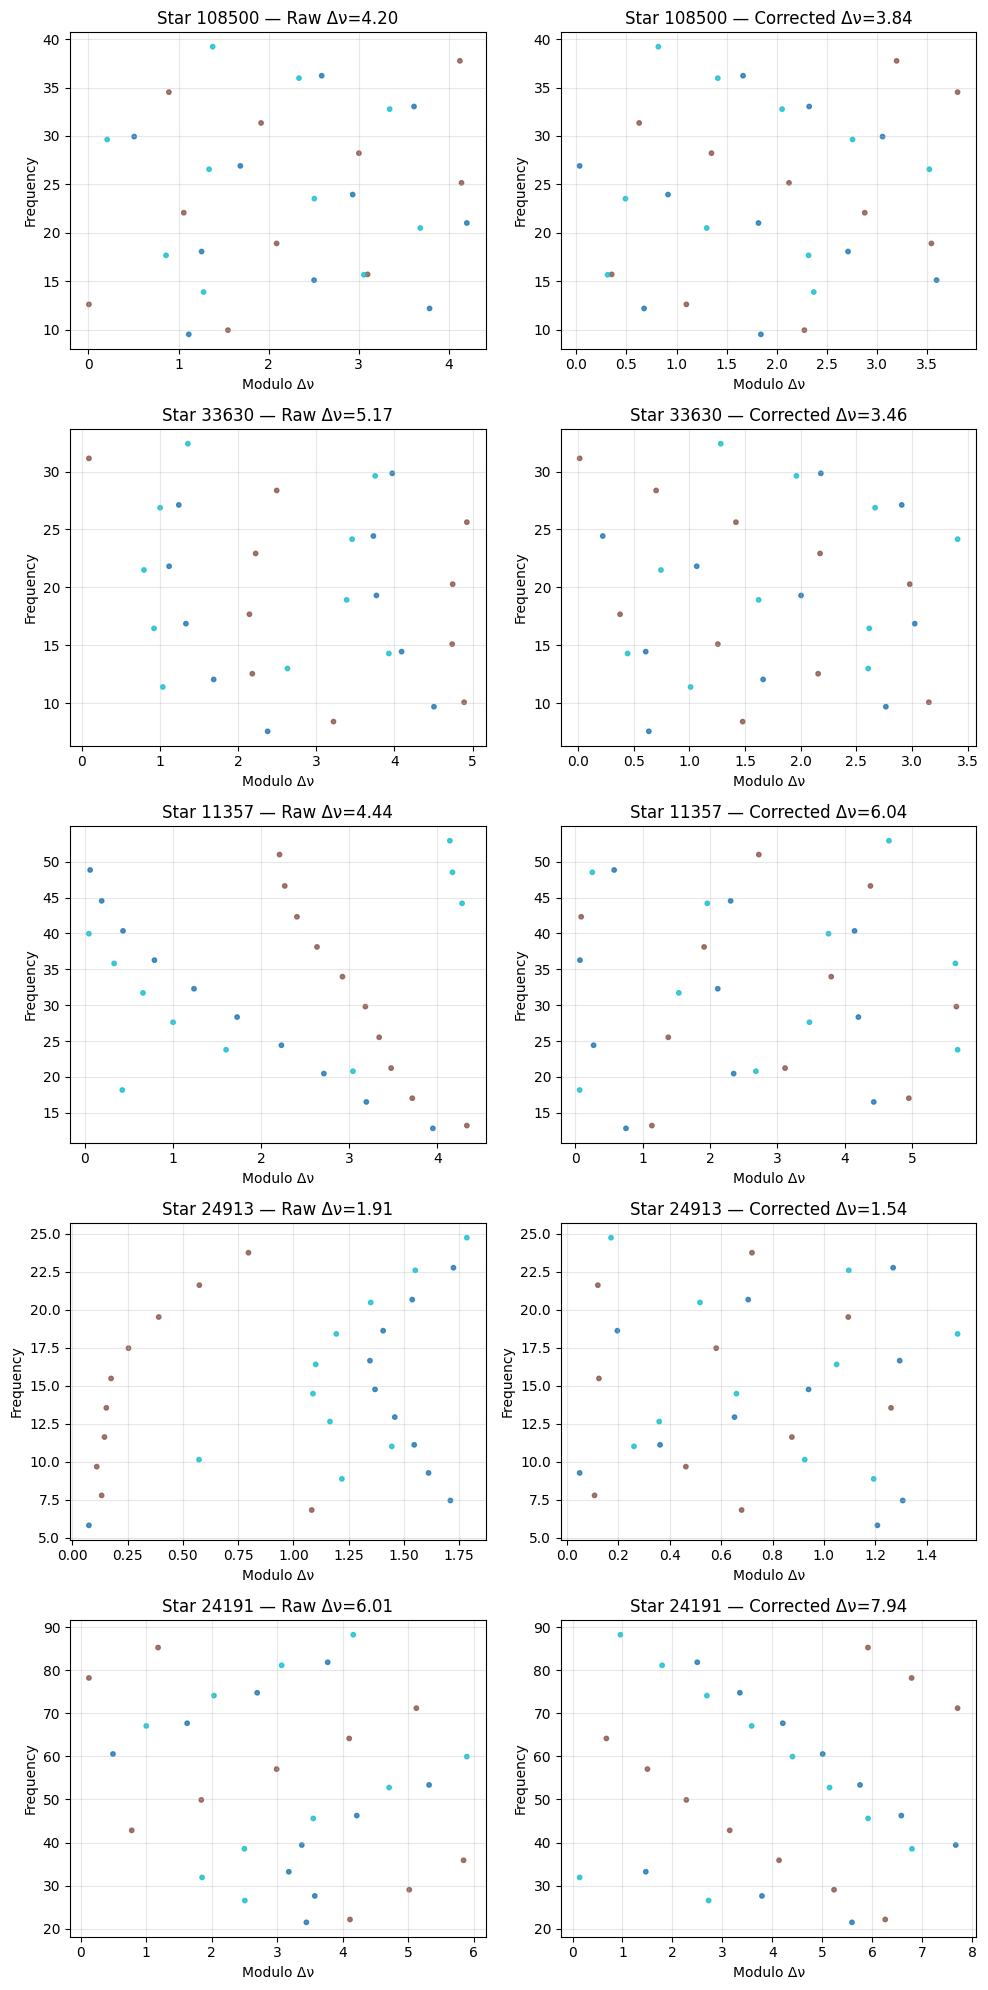

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_echelle_diagnostics(model, X, y, star_indices, n_samples=3):
    """
    Plot raw vs corrected echelle diagrams for randomly chosen stars.
    X: (N_stars, N_points, 2) input tensor
    y: (N_stars, N_points) labels
    star_indices: torch.arange(N_stars) or a subset
    """
    model.eval()
    n_stars = X.shape[0]
    chosen = np.random.choice(n_stars, size=min(n_samples, n_stars), replace=False)

    fig, axes = plt.subplots(len(chosen), 2, figsize=(10, 4*len(chosen)))
    if len(chosen) == 1:
        axes = np.expand_dims(axes, 0)  # keep consistent 2D indexing

    with torch.no_grad():
        for row, idx in enumerate(chosen):
            # Extract one star’s data
            x_star = X[idx:idx+1]  # (1,N,2)
            y_star = y[idx]        # (N,)
            star_idx = star_indices[idx:idx+1]

            freq = x_star[:, :, 0]                # (1,N)
            modf = model.delta_nu_module(freq, star_idx)  # (1,N)

            # Also compute corrected modulo view
            delta = (model.delta_nu_module.delta_nu_hard[star_idx] +
                     model.delta_nu_module.delta_nu_corr[star_idx]).item()

            # Classic echelle folding (modulo Δν)
            freq_raw_folded = (freq.squeeze().cpu().numpy() % model.delta_nu_module.delta_nu_hard[star_idx].item())
            freq_corr_folded = (freq.squeeze().cpu().numpy() % delta)

            # Prepare labels
            labels = y_star.cpu().numpy()

            # --- Left: original hardcoded Δν ---
            sc1 = axes[row,0].scatter(freq_raw_folded, freq.squeeze().cpu().numpy(),
                                      c=labels, cmap="tab10", s=10, alpha=0.8)
            axes[row,0].set_title(f"Star {idx} — Raw Δν={model.delta_nu_module.delta_nu_hard[star_idx].item():.2f}")

            # --- Right: corrected Δν ---
            sc2 = axes[row,1].scatter(freq_corr_folded, freq.squeeze().cpu().numpy(),
                                      c=labels, cmap="tab10", s=10, alpha=0.8)
            axes[row,1].set_title(f"Star {idx} — Corrected Δν={delta:.2f}")

            for ax in axes[row]:
                ax.set_xlabel("Modulo Δν")
                ax.set_ylabel("Frequency")
                ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_echelle_diagnostics(model, X_train, y_train, star_indices_train, n_samples=5)


In [ ]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# How many random stars to visualize
n_samples = 5
n_stars_total = X.shape[0]

# Randomly pick star indices
sample_indices = np.random.choice(n_stars_total, size=n_samples, replace=False)

# Convert to tensor for indexing
sample_indices_tensor = torch.tensor(sample_indices)

# Original hardcoded delta nu
delta_nu_hard = model.delta_nu_module.delta_nu_hard[sample_indices_tensor]  # (n_samples, 1)
# Learned correction
delta_nu_corr = model.delta_nu_module.delta_nu_corr[sample_indices_tensor]  # (n_samples, 1)
# Effective delta nu
delta_nu_eff = delta_nu_hard + delta_nu_corr

for i, star_idx in enumerate(sample_indices):
    freqs = X[star_idx,:,0].numpy()
    
    # Original modulo
    mod_orig = freqs % delta_nu_hard[i].item()
    
    # Corrected modulo
    mod_corr = freqs % delta_nu_eff[i].item()
    
    plt.figure(figsize=(8,4))
    plt.scatter(freqs, mod_orig, label='Original Δν', alpha=0.6)
    plt.scatter(freqs, mod_corr, label='Corrected Δν', alpha=0.6)
    plt.xlabel("Frequency")
    plt.ylabel("Frequency mod Δν")
    plt.title(f"Star index {star_idx}: Δν hard = {delta_nu_hard[i].item():.2f}, Δν corr = {delta_nu_corr[i].item():.2f}")
    plt.legend()
    plt.show()


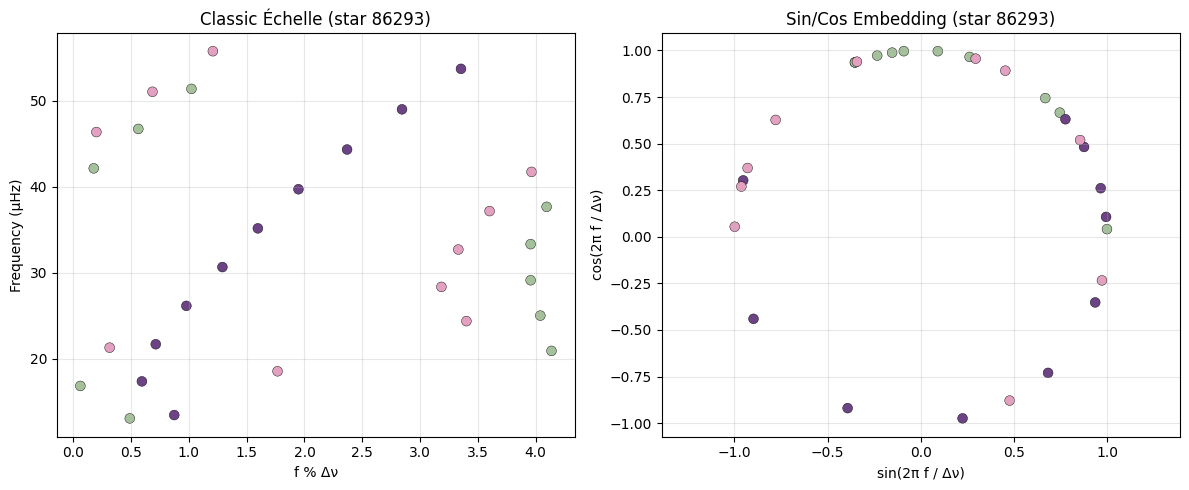

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: pick a random star and use its frequencies
star_idx = np.random.randint(0, X_tensor.shape[0])
freqs = X_tensor[star_idx, :, 0].numpy()
delta_nu_star = grid["delta_nu"].iloc[star_idx]

# Classic echelle (frequency modulo delta nu)
mod_freqs = freqs % delta_nu_star

# Sin/cos embedding
sin_feat = np.sin(2 * np.pi * freqs / delta_nu_star)
cos_feat = np.cos(2 * np.pi * freqs / delta_nu_star)

# Map colors by true mode degree l
REAL_CLASSES = [0, 1, 2]
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0'}

y_labels = y_tensor[star_idx].numpy()
colors = [color_map[int(l)] for l in y_labels]

plt.figure(figsize=(12, 5))

# Left: classic échelle
plt.subplot(1, 2, 1)
plt.scatter(mod_freqs, freqs, c=colors, s=50, edgecolor="k", linewidth=0.3)
plt.xlabel("f % Δν")
plt.ylabel("Frequency (μHz)")
plt.title(f"Classic Échelle (star {star_idx})")
plt.grid(alpha=0.3)

# Right: sin/cos embedding
plt.subplot(1, 2, 2)
plt.scatter(sin_feat, cos_feat, c=colors, s=50, edgecolor="k", linewidth=0.3)
plt.xlabel("sin(2π f / Δν)")
plt.ylabel("cos(2π f / Δν)")
plt.title(f"Sin/Cos Embedding (star {star_idx})")
plt.axis("equal")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


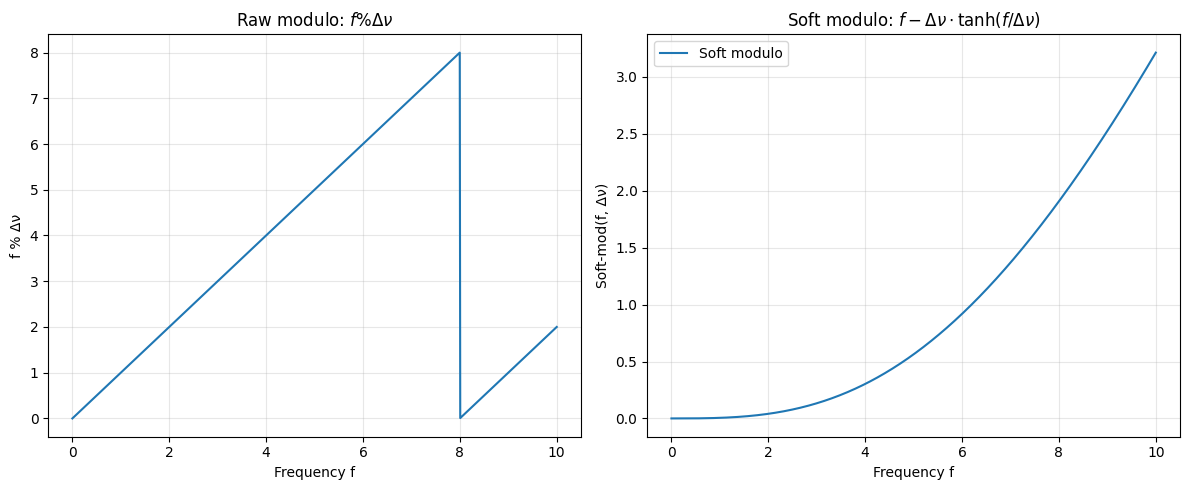

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define functions
def raw_mod(f, delta_nu):
    return f % delta_nu

def soft_mod(f, delta_nu):
    return f - delta_nu * torch.tanh(f / delta_nu)

f = torch.linspace(0, 10, 1000)
delta_nu = 8.0

# Compute outputs
y_raw = raw_mod(f, delta_nu)
y_soft = soft_mod(f, delta_nu)

# Compute gradients w.r.t delta_nu
delta_nu_var = torch.tensor(delta_nu, requires_grad=True)
y_raw_grad = ((f % delta_nu_var).clone()).detach()  # gradient of modulo is basically zero except jumps
y_soft_grad = soft_mod(f, delta_nu_var)
y_soft_grad.backward(torch.ones_like(f))
grad_soft = delta_nu_var.grad.item()

# Plot
plt.figure(figsize=(12,5))

# Left: raw modulo
plt.subplot(1,2,1)
plt.plot(f.numpy(), y_raw.numpy())
plt.title("Raw modulo: $f \\% \\Delta \\nu$")
plt.xlabel("Frequency f")
plt.ylabel("f % Δν")
plt.grid(alpha=0.3)

# Right: soft modulo
plt.subplot(1,2,2)
plt.plot(f.numpy(), y_soft.detach().numpy(), label="Soft modulo")
plt.title("Soft modulo: $f - Δν \\cdot \\tanh(f/Δν)$")
plt.xlabel("Frequency f")
plt.ylabel("Soft-mod(f, Δν)")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch

# Number of stars in your dataset
num_stars = len(grid)

# Base delta nu tensor
delta_nu_base = torch.tensor(grid["delta_nu"].values, dtype=torch.float32)


def apply_data_dropper(x, y, dropout_prob=0.3):
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()
    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0
    y_dropped = y.clone()
    y_dropped[mask == 0] = 3  # label for dropped points
    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats

model = SegmentationPointNet(num_stars=num_stars, num_classes=4)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
loss_fn = nn.NLLLoss(reduction="mean")

Nepoch = 150
nbatches = 100
batch_size = X_train.shape[0] // nbatches
history_train, history_test = [], []

for epoch in range(Nepoch):
    model.train()
    # Shuffle each epoch
    perm = torch.randperm(X_train.shape[0])
    X_train = X_train[perm]
    y_train = y_train[perm]
    star_ids_train = star_ids_train[perm]

    for i in range(nbatches):
        optimizer.zero_grad()
        start = i * batch_size
        end = (i + 1) * batch_size

        x_batch = X_train[start:end]
        y_batch = y_train[start:end]
        star_ids_batch = star_ids_train[start:end]

        x_dropped, y_dropped, mask, drop_stats = apply_data_dropper(x_batch, y_batch, dropout_prob=0.3)

        seg_output = model(x_dropped, star_ids_batch, delta_nu_base)
        cost = loss_fn(seg_output.permute(0, 2, 1), y_dropped)
        cost.backward()
        optimizer.step()

    # Validation / test: apply the SAME dropper probability to test set
    model.eval()
    with torch.no_grad():
        x_test_dropped, y_test_dropped, mask_test, _ = apply_data_dropper(X_test, y_test, dropout_prob=0.3)
        seg_out_test = model(x_test_dropped, star_ids_test, delta_nu_base)
        cost_test = loss_fn(seg_out_test.permute(0, 2, 1), y_test_dropped)

    history_train.append(float(cost))
    history_test.append(float(cost_test))

    pred_classes = seg_out_test.argmax(dim=2)
    mask_valid = y_test_dropped != 3
    acc = (pred_classes[mask_valid] == y_test_dropped[mask_valid]).float().mean()

    print(f"Epoch {epoch}: Train Loss={cost:.4f}, Test Loss={cost_test:.4f}, Acc={acc:.4f}")

NameError: name 'star_ids_train' is not defined

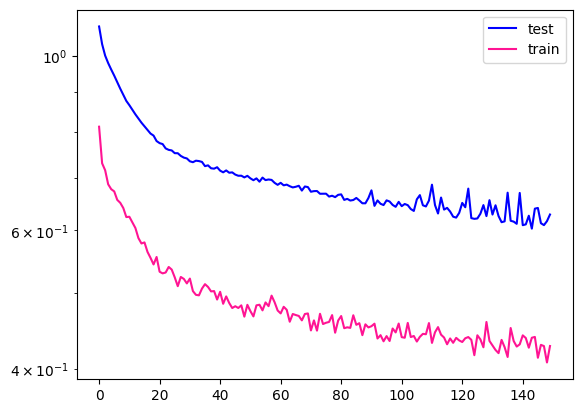

In [7]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

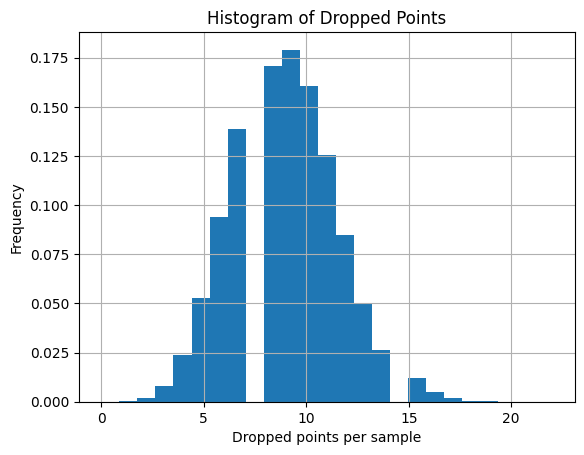

In [9]:
# of course we still want to know what the distribution of dropped frequencies looks like 

import matplotlib.pyplot as plt

plt.hist(all_drop_counts, bins=25, density=True)
plt.xlabel("Dropped points per sample")
plt.ylabel("Frequency")
plt.title("Histogram of Dropped Points")
plt.grid(True)
plt.show()

## Training - only shaker

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def add_noise(x, noise_std=0.2):
    """
    teeny tiny RANDOM Gaussian noise to inputs.
    """
    noise = torch.randn_like(x) * noise_std
    return x + noise

Nepoch = 150
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean", ignore_index=-1)

history_train, history_test = [], []
history_train_acc, history_test_acc = [], []

inpt_test = inpt
target_test = y_train[:inpt.shape[0]]

for epoch in range(Nepoch):
    model.train()
    for i in range(nbatches):
        optimizer.zero_grad()
        x_batch = X_train[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        # add noise
        x_noisy = add_noise(x_batch, noise_std=0.2)

        # forward pass
        seg_output = model(x_noisy)
        seg_output = seg_output.permute(0, 2, 1)   # [batch, classes, points]

        # loss
        loss = loss_fn(seg_output, y_batch)
        cost = loss.mean()
        cost.backward()
        optimizer.step()

    # evaluation
    model.eval()
    with torch.no_grad():
        seg_out_test = model(inpt_test)
        seg_out_test = seg_out_test.permute(0, 2, 1)

        cost_test = loss_fn(seg_out_test, target_test)

        # accuracy train (last mini-batch only)
        train_preds = seg_output.argmax(dim=1)
        valid_mask_train = y_batch != -1
        correct_train = (train_preds[valid_mask_train] == y_batch[valid_mask_train]).sum().item()
        total_train = valid_mask_train.sum().item()
        train_acc = correct_train / total_train if total_train > 0 else 0.0

        # accuracy test
        test_preds = seg_out_test.argmax(dim=1)
        valid_mask_test = target_test != -1
        correct_test = (test_preds[valid_mask_test] == target_test[valid_mask_test]).sum().item()
        total_test = valid_mask_test.sum().item()
        test_acc = correct_test / total_test if total_test > 0 else 0.0

    history_train.append(float(cost))
    history_test.append(float(cost_test))
    history_train_acc.append(train_acc)
    history_test_acc.append(test_acc)

    print(f"Epoch {epoch}: "
          f"Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}, "
          f"Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

Epoch 0: Train Loss = 1.0262, Test Loss = 1.0181, Train Acc = 0.4610, Test Acc = 0.4797
Epoch 1: Train Loss = 0.9606, Test Loss = 0.9480, Train Acc = 0.4810, Test Acc = 0.4882
Epoch 2: Train Loss = 0.9177, Test Loss = 0.9051, Train Acc = 0.5213, Test Acc = 0.5259
Epoch 3: Train Loss = 0.8670, Test Loss = 0.8555, Train Acc = 0.5547, Test Acc = 0.5990
Epoch 4: Train Loss = 0.8013, Test Loss = 0.8370, Train Acc = 0.6080, Test Acc = 0.6008
Epoch 5: Train Loss = 0.7415, Test Loss = 0.7523, Train Acc = 0.6887, Test Acc = 0.6973
Epoch 6: Train Loss = 0.7032, Test Loss = 0.7199, Train Acc = 0.7017, Test Acc = 0.7120
Epoch 7: Train Loss = 0.6721, Test Loss = 0.6732, Train Acc = 0.7223, Test Acc = 0.7445
Epoch 8: Train Loss = 0.6472, Test Loss = 0.6344, Train Acc = 0.7357, Test Acc = 0.7749
Epoch 9: Train Loss = 0.6260, Test Loss = 0.6172, Train Acc = 0.7433, Test Acc = 0.7698
Epoch 10: Train Loss = 0.6050, Test Loss = 0.5977, Train Acc = 0.7540, Test Acc = 0.7778
Epoch 11: Train Loss = 0.5988, 

In [ ]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

## Training - drop and shake

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


def apply_data_dropper(x, y, dropout_prob=0.3):
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()

    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0

    y_dropped = y.clone()
    y_dropped[mask == 0] = 3  # new label for dropped points = 3

    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats

def add_noise(x, noise_std=0.2):
    """tiny Gaussian noise"""
    noise = torch.randn_like(x) * noise_std
    return x + noise


# --- Hyperparams ---
Nepoch = 150
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

# --- Optimizer & loss ---
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean")

# --- History trackers ---
history_train, history_test = [], []
history_train_acc, history_test_acc = [], []
all_drop_counts = []

# --- Test input ---
inpt_test = inpt
target_test = y_train[:inpt.shape[0]]

for epoch in range(Nepoch):
    model.train()

    for i in range(nbatches):
        optimizer.zero_grad()

        x_batch = inpt[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        # Dropout & noise
        x_dropped, y_dropped, mask, drop_stats = apply_data_dropper(x_batch, y_batch, dropout_prob=0.3)
        all_drop_counts.extend(drop_stats.cpu().tolist())
        x_noisy = add_noise(x_dropped, noise_std=0.2)

        # Forward
        seg_output = model(x_noisy)  # (B, N, C)
        seg_output = seg_output.permute(0, 2, 1)  # (B, C, N)

        # Loss
        cost = loss_fn(seg_output, y_dropped)
        cost.backward()
        optimizer.step()

    # --- Evaluation ---
    model.eval()
    with torch.no_grad():
        seg_out_test = model(inpt_test).permute(0, 2, 1)
        cost_test = loss_fn(seg_out_test, target_test)

        # Train accuracy (last mini-batch of epoch)
        train_preds = seg_output.argmax(dim=1)  # (B, N)
        mask_train = y_dropped != 3
        correct_train = (train_preds[mask_train] == y_dropped[mask_train]).sum().item()
        total_train = mask_train.sum().item()
        train_acc = correct_train / total_train if total_train > 0 else 0.0

        # Test accuracy
        test_preds = seg_out_test.argmax(dim=1)
        mask_test = target_test != 3
        correct_test = (test_preds[mask_test] == target_test[mask_test]).sum().item()
        total_test = mask_test.sum().item()
        test_acc = correct_test / total_test if total_test > 0 else 0.0

    # --- Track ---
    history_train.append(float(cost))
    history_test.append(float(cost_test))
    history_train_acc.append(train_acc)
    history_test_acc.append(test_acc)

    print(f"Epoch {epoch}: "
          f"Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}, "
          f"Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")


## Training - only faker!!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

FAKE_CLASS = 3
DROPPED_CLASS = -1
MAX_FAKE_FRACTION = 0.2
Nepoch = 150
nbatches = 100
learning_rate = 0.0005
loss_fn = nn.NLLLoss(reduction="mean", ignore_index=DROPPED_CLASS)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
history_train, history_test = [], []
history_train_acc, history_test_acc = [], []

batch_size = inpt.size(0) // nbatches
inpt_test = inpt
target_test = y_train[:inpt.shape[0]]

def inject_fake_frequencies(x, y, max_fake_fraction=MAX_FAKE_FRACTION, num_fake_points=10):
    valid_mask = y != DROPPED_CLASS
    x_real = x[valid_mask]
    if x_real.shape[0] < 2: return x, y, None
    freqs, mods = x_real[:,0], x_real[:,1]
    f_min, f_max = freqs.min().item(), freqs.max().item()
    mod_min, mod_max = mods.min().item(), mods.max().item()
    n_fake = min(num_fake_points, int(len(freqs) * max_fake_fraction))
    if n_fake <= 0: return x, y, None
    f_fake = torch.rand(n_fake, device=x.device) * (f_max - f_min) + f_min
    mod_fake = torch.rand(n_fake, device=x.device) * (mod_max - mod_min) + mod_min
    fake_pts = torch.stack([f_fake, mod_fake], dim=1)
    x_aug = torch.cat([x, fake_pts], dim=0)
    y_aug = torch.cat([y, torch.full((n_fake,), FAKE_CLASS, dtype=torch.long, device=x.device)], dim=0)
    return x_aug, y_aug, fake_pts


for epoch in range(Nepoch):
    model.train()
    train_acc_epoch = []

    for i in range(nbatches):
        optimizer.zero_grad()
        # --- Slice batch ---
        x_batch = inpt[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        # --- Inject fake points & pad ---
        x_aug_list, y_aug_list = [], []
        for j in range(x_batch.shape[0]):
            xj, yj, _ = inject_fake_frequencies(x_batch[j], y_batch[j])
            x_aug_list.append(xj)
            y_aug_list.append(yj)

        max_len = max(x.shape[0] for x in x_aug_list)
        x_padded = torch.zeros(len(x_aug_list), max_len, 2, device=inpt.device)
        y_padded = torch.full((len(y_aug_list), max_len), DROPPED_CLASS, dtype=torch.long, device=inpt.device)
        for j, (xj, yj) in enumerate(zip(x_aug_list, y_aug_list)):
            x_padded[j, :xj.shape[0], :] = xj
            y_padded[j, :yj.shape[0]] = yj

        star_indices = torch.arange(x_padded.size(0), device=x_padded.device)
        logits, delta_pred = model(x_padded, star_indices=star_indices)
        seg_output = logits.permute(0, 2, 1)  # (B, num_classes, seq_len)
        loss = loss_fn(seg_output, y_padded)
        loss.backward()

        pred_classes = seg_output.argmax(dim=1)
        mask_valid = y_padded != DROPPED_CLASS
        batch_acc = (pred_classes[mask_valid] == y_padded[mask_valid]).float().mean().item()
        train_acc_epoch.append(batch_acc)

    model.eval()
    with torch.no_grad():
        star_indices_test = torch.arange(inpt_test.size(0), device=inpt_test.device)
        logits_test, _ = model(inpt_test, star_indices=star_indices_test)
        seg_out_test = logits_test.permute(0, 2, 1)
        val_loss = loss_fn(seg_out_test, target_test)

        train_preds = seg_output.argmax(dim=1)
        train_acc = (train_preds[mask_valid] == y_padded[mask_valid]).float().mean().item()
        test_preds = seg_out_test.argmax(dim=1)
        test_acc = (test_preds[target_test!=DROPPED_CLASS] == target_test[target_test!=DROPPED_CLASS]).float().mean().item()

    history_train.append(float(loss))
    history_test.append(float(val_loss))
    history_train_acc.append(train_acc)
    history_test_acc.append(test_acc)

    print(f"Epoch {epoch}: Train Loss = {loss:.4f}, Test Loss = {val_loss:.4f}, "
          f"Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

Epoch 0: Train Loss = 2.4952, Test Loss = 3.0093, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 1: Train Loss = 2.4959, Test Loss = 3.0092, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 2: Train Loss = 2.4945, Test Loss = 3.0093, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 3: Train Loss = 2.4946, Test Loss = 3.0094, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 4: Train Loss = 2.4949, Test Loss = 3.0092, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 5: Train Loss = 2.4941, Test Loss = 3.0092, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 6: Train Loss = 2.4935, Test Loss = 3.0092, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 7: Train Loss = 2.4944, Test Loss = 3.0094, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 8: Train Loss = 2.4956, Test Loss = 3.0092, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 9: Train Loss = 2.4948, Test Loss = 3.0094, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 10: Train Loss = 2.4958, Test Loss = 3.0093, Train Acc = 0.1667, Test Acc = 0.0000
Epoch 11: Train Loss = 2.4957, 

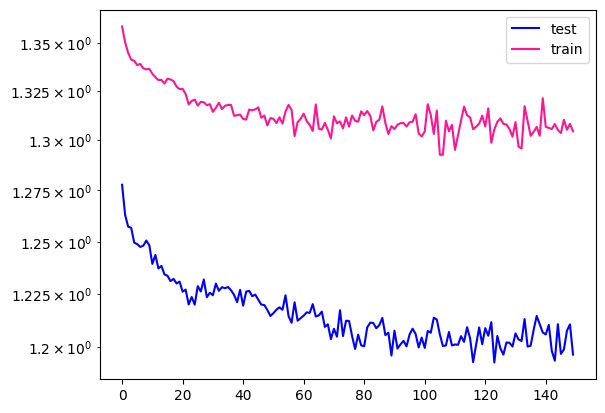

In [8]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

## Training - drop, shake and fake! NO LR schedule and NO Early Stopping

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

FAKE_CLASS = 3
DROPPED_CLASS = -1
DROP_PROB = 0.2
SHAKE_STD = 0.05
MAX_FAKE_FRACTION = 0.2
Nepoch = 150
nbatches = 100
learning_rate = 0.001

def apply_dropper(x, y, dropout_prob=DROP_PROB):
    keep_mask = torch.rand(x.shape[0]) > dropout_prob
    x_dropped = x.clone()
    y_dropped = y.clone()
    y_dropped[~keep_mask] = DROPPED_CLASS
    return x_dropped, y_dropped, keep_mask

def apply_shaker(x, keep_mask, shake_std=SHAKE_STD):
    x_shaken = x.clone()
    x_shaken[keep_mask] += torch.randn_like(x_shaken[keep_mask]) * shake_std
    return x_shaken

def inject_fake_frequencies(x, y, max_fake_fraction=MAX_FAKE_FRACTION, num_fake_points=10):
    valid_mask = y != DROPPED_CLASS
    x_real = x[valid_mask]
    if x_real.shape[0] < 2:
        return x, y, None
    freqs = x_real[:, 0]
    f_min, f_max = freqs.min().item(), freqs.max().item()
    mods = x_real[:, 1]
    mod_min, mod_max = mods.min().item(), mods.max().item()
    n_real = x_real.shape[0]
    n_fake = min(num_fake_points, int(n_real * max_fake_fraction))
    if n_fake <= 0:
        return x, y, None
    f_fake = torch.rand(n_fake, device=x.device) * (f_max - f_min) + f_min
    mod_fake = torch.rand(n_fake, device=x.device) * (mod_max - mod_min) + mod_min
    fake_points = torch.stack([f_fake, mod_fake], dim=1)
    x_aug = torch.cat([x, fake_points], dim=0)
    y_aug = torch.cat([y, torch.full((n_fake,), FAKE_CLASS, dtype=torch.long, device=x.device)], dim=0)
    return x_aug, y_aug, fake_points

history_train, history_test = [], []
history_train_acc, history_test_acc = [], []

batch_size = inpt.size(0) // nbatches
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean", ignore_index=DROPPED_CLASS)

target_test = y_train[:inpt.shape[0]]
inpt_test = inpt

for epoch in range(Nepoch):
    model.train()
    train_acc_epoch = []

    for i in range(nbatches):
        optimizer.zero_grad()
        i0 = i * batch_size
        i1 = min((i + 1) * batch_size, inpt.size(0))
        if i0 >= i1:
            continue

        x_batch = inpt[i0:i1]
        y_batch = target_test[i0:i1]
        star_indices = torch.arange(i0, i1)  # <--- important

        x_aug_list, y_aug_list = [], []

        for j in range(x_batch.shape[0]):
            x_dropped, y_dropped, keep_mask = apply_dropper(x_batch[j], y_batch[j])
            x_shaken = apply_shaker(x_dropped, keep_mask)
            x_aug, y_aug, _ = inject_fake_frequencies(x_shaken, y_dropped, max_fake_fraction=MAX_FAKE_FRACTION)
            x_aug_list.append(x_aug)
            y_aug_list.append(y_aug)

        max_len = max(x.shape[0] for x in x_aug_list)
        x_padded = torch.zeros(len(x_aug_list), max_len, 2)
        y_padded = torch.full((len(y_aug_list), max_len), DROPPED_CLASS)

        for j, (xj, yj) in enumerate(zip(x_aug_list, y_aug_list)):
            x_padded[j, :xj.shape[0]] = xj
            y_padded[j, :yj.shape[0]] = yj

        seg_output = model(x_padded, star_indices=star_indices)  # <--- FIXED
        cost = loss_fn(seg_output.permute(0, 2, 1), y_padded)
        cost.backward()
        optimizer.step()

        pred_classes = seg_output.argmax(dim=2)
        mask_valid = y_padded != DROPPED_CLASS
        batch_acc = (pred_classes[mask_valid] == y_padded[mask_valid]).float().mean().item()
        train_acc_epoch.append(batch_acc)

    model.eval()
    with torch.no_grad():
        star_indices_test = torch.arange(inpt_test.size(0))
        seg_out_test = model(inpt_test, star_indices=star_indices_test)  # <--- FIXED
        cost_test = loss_fn(seg_out_test.permute(0, 2, 1), target_test)
        pred_test = seg_out_test.argmax(dim=2)
        mask_test = target_test != DROPPED_CLASS
        test_acc = (pred_test[mask_test] == target_test[mask_test]).float().mean().item()

    history_train.append(float(cost))
    history_test.append(float(cost_test))
    history_train_acc.append(sum(train_acc_epoch) / len(train_acc_epoch))
    history_test_acc.append(test_acc)

    print(f"Epoch {epoch}: Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}, "
          f"Train Acc = {history_train_acc[-1]:.4f}, Test Acc = {test_acc:.4f}")

Epoch 0: Train Loss = 1.3500, Test Loss = 1.2553, Train Acc = 0.2938, Test Acc = 0.3585
Epoch 1: Train Loss = 1.3440, Test Loss = 1.2507, Train Acc = 0.3081, Test Acc = 0.3713
Epoch 2: Train Loss = 1.3380, Test Loss = 1.2409, Train Acc = 0.3106, Test Acc = 0.3729
Epoch 3: Train Loss = 1.3313, Test Loss = 1.2466, Train Acc = 0.3136, Test Acc = 0.3758
Epoch 4: Train Loss = 1.3314, Test Loss = 1.2489, Train Acc = 0.3138, Test Acc = 0.3754
Epoch 5: Train Loss = 1.3302, Test Loss = 1.2427, Train Acc = 0.3158, Test Acc = 0.3769
Epoch 6: Train Loss = 1.3277, Test Loss = 1.2328, Train Acc = 0.3180, Test Acc = 0.3783
Epoch 7: Train Loss = 1.3259, Test Loss = 1.2392, Train Acc = 0.3197, Test Acc = 0.3779
Epoch 8: Train Loss = 1.3225, Test Loss = 1.2403, Train Acc = 0.3194, Test Acc = 0.3812
Epoch 9: Train Loss = 1.3204, Test Loss = 1.2297, Train Acc = 0.3198, Test Acc = 0.3829
Epoch 10: Train Loss = 1.3193, Test Loss = 1.2357, Train Acc = 0.3209, Test Acc = 0.3740
Epoch 11: Train Loss = 1.3194, 

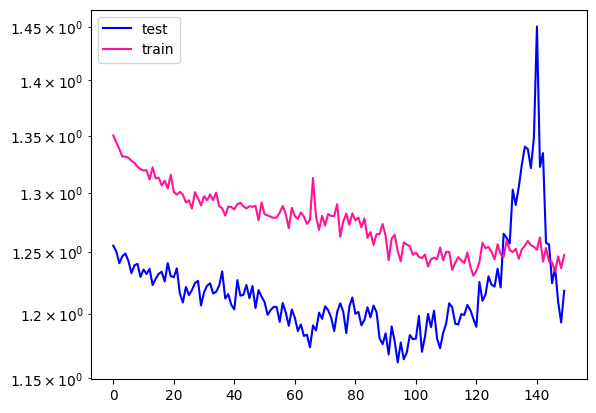

In [7]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()